<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/machine_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer látás betanított modellek alapján

**Megjegyzés**

Kérjük kapcsolja be a GPU támogatást a Colab virtuális gépen. Válassza a  menüből az
**Edit/Notebook settings** és válassza a T4 GPU-t. Ezután a következő kódblokknak a *Tesla T4* szöveget kell kiírnia.

In [1]:
!nvidia-smi -q -i 0 | grep "Product Name"

    Product Name                          : Tesla T4


## Kép osztályozás

A mesterséges intelligencia, gépi tanulás és neurális hálózatok segítségével egyre jobb modelleket dolgoznak ki a képek osztályozására.
A megoldandó feladat, hogy egy eddig nem látott képet "megmutatva" a modell felhasználásával a számítógép mondja meg, ogy mi van a képen. Számos kész, szabadon letölthető, már betanított modell is rendelkezésünkre áll.

Először a DenseNet-Caffe modellt (Densely Connected Convolutional Networks - https://arxiv.org/abs/1608.06993) használjuk az ImageNet Large Scale Visual Recognition Challenge 2012 (ILSVRC2012) versenyéről. 1000 osztály megkülönböztetésére tanították meg a modellt



In [2]:
import requests
import imutils
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL

Először töltsük le a betanított *caffe* modelt.



In [3]:
!mkdir sample_data
!wget -q -O sample_data/classification_classes_ILSVRC2012.txt https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/classification_classes_ILSVRC2012.txt
!wget -q -O sample_data/DenseNet_121.caffemodel https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/DenseNet_121.caffemodel
!wget -q -O sample_data/DenseNet_121.prototxt https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/DenseNet_121.prototxt

mkdir: cannot create directory ‘sample_data’: File exists


Töltsük be a letöltött modellt.

In [4]:
# ImageNet osztály nevek
with open('sample_data/classification_classes_ILSVRC2012.txt', 'r') as f:
   class_names = f.read().split('\n')
model = cv2.dnn.readNet(model='sample_data/DenseNet_121.caffemodel',
                        config='sample_data/DenseNet_121.prototxt',
                        framework='Caffe')
print(class_names[:20])

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee']


Egy Python függvényt készítünk egy kép osztályozásához. Az előfeldolgozás során átméretezzük a képet és az átlagot levonjuk.

In [5]:
def classify_img(image, model):
    """ kép osztályozás caffe modellel """
    # blob készítése a képböl 224 x 224 méretre csökkentés
    blob = cv2.dnn.blobFromImage(image=image, scalefactor=0.01, size=(224, 224),
                                 mean=(104, 117, 123))
    model.setInput(blob)        # bemenet beállítása a neurális hálózathoz

    outputs = model.forward()   # kép átküldése a neurális hálón
    final_outputs = outputs[0]
    final_outputs = final_outputs.reshape(1000, 1)  # 1D többé konvertálás

    label_id = np.argmax(final_outputs) # legnagyobb valószínűségű osztály indexe
    # convert the output scores to softmax probabilities
    probs = np.exp(final_outputs) / np.sum(np.exp(final_outputs))
    final_prob = np.max(probs)      # legnagyobb valószínűség értéke
    out_name = class_names[label_id]
    out_text = f"{out_name}, {final_prob:.1%}"
    fig, ax = plt.subplots(1, 1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(out_text)
    ax.axis('off')

Egy minta kép letöltése a BME épületek közötti átjáróról.

In [6]:
!wget -q -O sample_data/sh1.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/sh1.jpg

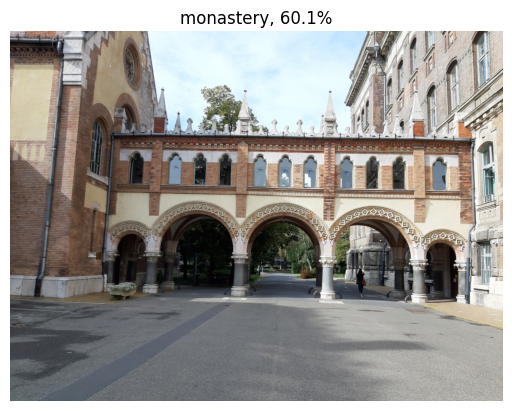

In [7]:
img1 = cv2.imread('sample_data/sh1.jpg')
classify_img(img1, model)

A modell szerint egy kolostort ábrázol a kép.

Az alábbi *urls* listát kibővíthetjük, felülírhatjuk az interneten található képek linkjével.

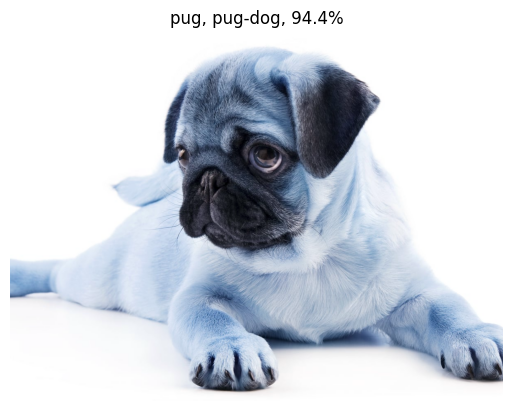

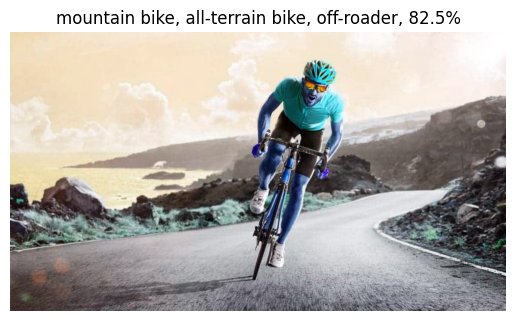

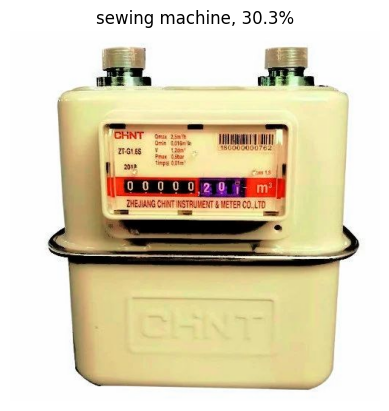

In [9]:
urls = ['https://i.guim.co.uk/img/media/fe1e34da640c5c56ed16f76ce6f994fa9343d09d/0_174_3408_2046/master/3408.jpg?width=1200&height=900&quality=85&auto=format&fit=crop&s=0d3f33fb6aa6e0154b7713a00454c83d',
        'https://lemonbin.com/wp-content/uploads/2020/06/cyclist-june172020-min.jpg',
        'https://5.imimg.com/data5/TestImages/LC/LC/YS/SELLER-18789923/domestic-diaphragm-type-gas-meter-500x500.jpg']
for url in urls:
    im = np.array(PIL.Image.open(requests.get(url, stream=True).raw))
    classify_img(im, model)

## CIFAR-10 minta adatok

A CIFAR-10 adatrendszer 60000 32 x 32 felbontású színes képet tartalmaz, melyeket 10 osztályba soroltak (https://www.cs.toronto.edu/~kriz/cifar.html).

Osztályok:

* repülőgép
* autó
* madár
* macska
* szarvas
* kutya
* béka
* ló
* hajó
* kamion

A Keras könyvtár segítségével hozzunk létre egy modellt.


In [10]:
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from pathlib import Path
from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image
import numpy as np

Töltsük le a minta képeket és nézzünk meg néhány véletlenszerűen képet.

170498071/170498071 [==============================] - 11s 0us/step


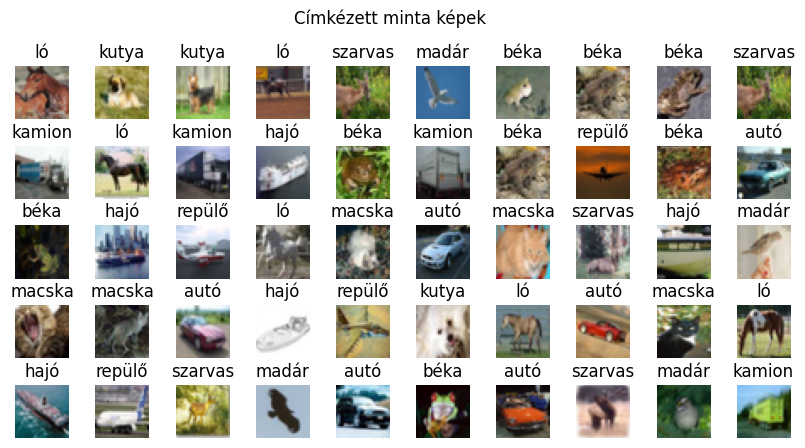

In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#                   0        1       2         3         4         5        6      7      8       9
class_labels = ["repülő", "autó", "madár", "macska", "szarvas", "kutya", "béka", "ló", "hajó", "kamion"]
num_classes = len(class_labels)

rows = 5; cols = 10
rand_ind = np.random.randint(0, high=1000, size=rows*cols, dtype=int)
fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
fig.suptitle('Címkézett minta képek')
axes = axes.ravel()

for i in np.arange(0, rows*cols):
    img_ind = rand_ind[i]
    axes[i].imshow(x_test[img_ind])
    axes[i].set_title(class_labels[int(y_test[img_ind][0])])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

Hozzuk létre a modellünket és tanítsuk be a CIFAR-10 adatkészlet felhasználásával. Ez néhány percet vesz igénybe.

Kétszer 32 darab, kétszer 64 darab és kétszer 128 darab 3 x 3-as konvolúciós szűrőt és egy rejtett réteget tartalmaz a modell.




In [12]:
%%time
# képek normalizálása a 0-1 tartományba
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Osztály címkék konvertálása bináris osztály mátrixá
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# modell létrehozása és rétegek hozzáadása
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 20
history = model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/20
782/782 [==============================] - 21s 14ms/step - loss: 1.7280 - accuracy: 0.4032 - val_loss: 1.6023 - val_accuracy: 0.4548
Epoch 2/20
782/782 [==============================] - 10s 13ms/step - loss: 1.1792 - accuracy: 0.5762 - val_loss: 1.1549 - val_accuracy: 0.5979
Epoch 3/20
782/782 [==============================] - 10s 13ms/step - loss: 0.9776 - accuracy: 0.6544 - val_loss: 0.9026 - val_accuracy: 0.6852
Epoch 4/20
782/782 [==============================] - 10s 13ms/step - loss: 0.8746 - accuracy: 0.6933 - val_loss: 0.8416 - val_accuracy: 0.7137
Epoch 5/20
782/782 [==============================] - 10s 13ms/step - loss: 0.8102 - accuracy: 0.7190 - val_loss: 0.6697 - val_accuracy: 0.7668
Epoch 6/20
782/782 [==============================] - 10s 13ms/step - loss: 0.7518 - accuracy: 0.7397 - val_loss: 0.8552 - val_accuracy: 0.7075
Epoch 7/20
782/782 [==============================] - 10s 13ms/step - loss: 0.7186 - accuracy: 0.7529 - val_loss: 0.8833 - val_accuracy:

Modell pontosság:89.1%
Teszt  pontosság:82.6%


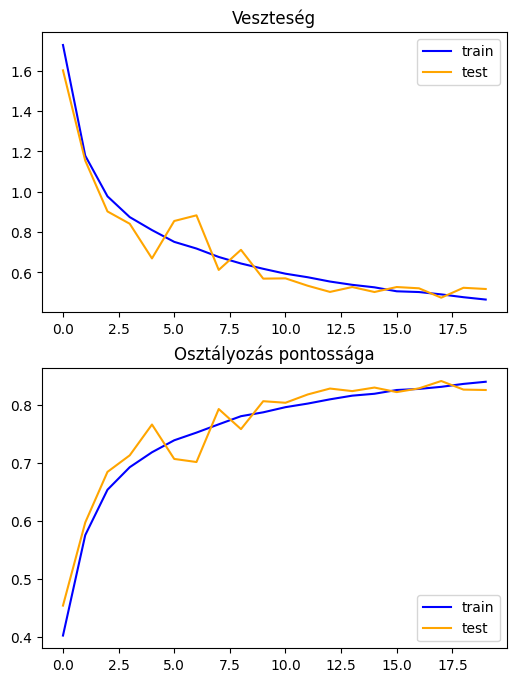

In [13]:
score, acc = model.evaluate(x_train, y_train, batch_size=64, verbose=0)
print(f'Modell pontosság:{acc:.1%}')
score, acc = model.evaluate(x_test, y_test, batch_size=64, verbose=0)
print(f'Teszt  pontosság:{acc:.1%}')
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].set_title('Veszteség')
ax[0].plot(history.history['loss'], color='blue', label='train')
ax[0].plot(history.history['val_loss'], color='orange', label='test')
ax[0].legend()
ax[1].set_title('Osztályozás pontossága')
ax[1].plot(history.history['accuracy'], color='blue', label='train')
ax[1].plot(history.history['val_accuracy'], color='orange', label='test')
ax[1].legend(loc=4)
plt.subplots_adjust(wspace=0.5)

313/313 [==============================] - 1s 2ms/step


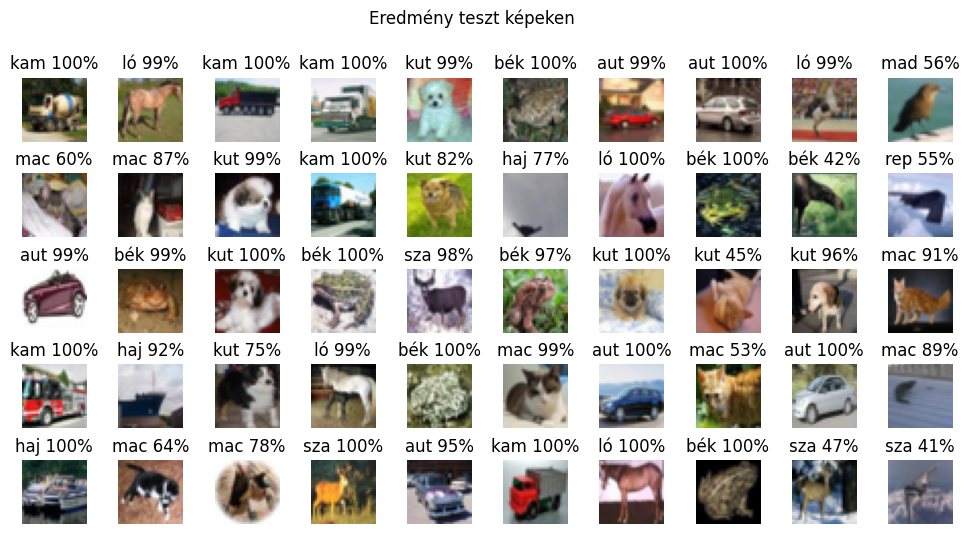

In [15]:
y_pred = model.predict(x_test)
rows = 5; cols = 10
rand_ind = np.random.randint(0, high=10000, size=rows*cols, dtype=int)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.2, rows * 1.2))
fig.suptitle('Eredmény teszt képeken')
axes = axes.ravel()

for i in np.arange(0, rows*cols):
    img_ind = rand_ind[i]
    axes[i].imshow(x_test[img_ind])
    k = np.argmax(y_pred[img_ind])
    axes[i].set_title(f"{class_labels[k][:3]} {y_pred[img_ind, k]:.0%}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

Próbáljuk ki a modellt eddig nem használt képeken!

In [16]:
# add more images here from the ten classes
!wget -q https://www.shutterstock.com/image-photo/forg-260nw-151350374.jpg
!wget -q https://imagestore1.blogger.hu/25_150709_854054_a2bb73f454241fc91a575ab9596916e3_e27a2a_301.jpg
!wget -q https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Female_bengal_cat_outdoor.jpg/250px-Female_bengal_cat_outdoor.jpg

In [17]:
# collecting images from local folder
import glob
images = glob.glob("*.png") + glob.glob("*.jpg")

Betöltjük a képeket és egy 4D numpy tömbbe tesszük őket.

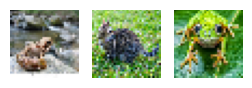

In [18]:
np_images = np.zeros((len(images), 32, 32, 3))
fig, ax = plt.subplots(1, len(images), figsize=(len(images), 1))
ax = ax.ravel()
for i, img_name in enumerate(images):
    # Load and resize to 32x32 pixels (as required by this model)
    img = image.load_img(img_name, target_size=(32, 32))
    # képek átalakítása numpy tömbökké és normalizálás
    np_images[i] = image.img_to_array(img).astype('float32') / 255.0
    ax[i].imshow(img)
    ax[i].axis('off')
#plt.subplots_adjust(wspace=0.5)

Making prediction from the model

In [19]:
results = model.predict(np_images)
preds = np.argmax(results, axis=1)

1/1 [==============================] - 0s 310ms/step


Eredmények kiírása

In [20]:
for i, pred in enumerate(preds):
    print(f"{images[i]} képen egy {class_labels[pred]} van ({results[i, pred]:.1%})")

forg-260nw-151350374.jpg képen egy béka van (90.7%)
250px-Female_bengal_cat_outdoor.jpg képen egy béka van (88.1%)
25_150709_854054_a2bb73f454241fc91a575ab9596916e3_e27a2a_301.jpg képen egy béka van (99.0%)


# Objektum detektálás YOLO5-el



A YOLO (You Only Look Once) modell egy képen több kisebb objektum detektálására képes, akár videó felvételeken valós időben. Tanítására az MS COCO adathalmazt használták, mely 80 objektum kategóriát és több mint 200000 címkézett képet tartalmaz.

In [21]:
# kész modell letöltése
%cd
!git clone -q https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt comet_ml  # szükséges Python modulok telepítése

/root
/root/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.4/779.4 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 31.2 MB/s eta 0:00:00
ERROR

In [22]:
import glob
import cv2
from matplotlib import pyplot as plt
import torch
import utils
display = utils.notebook_init()  # telepítés ellenőrzése

YOLOv5 🚀 v7.0-318-gc0380fd8 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 30.4/201.2 GB disk)


Feldolgozandó képek letöltése.

In [23]:
!wget -q -O data/images/stop.jpg https://cdn.powa.com/baderscott.com/images/wp-content/uploads/2020/06/atlanta-ga-car-accident-lawyer-running-a-stop-signal-300x200-245-critical-desktop.jpg.webp
#!wget -q -O data/images/president.jpg http://gita.hu/keptar/gita2022/IMG_7504.JPG
#!wget -q -O data/images/audience.jpg http://gita.hu/keptar/gita2022/IMG_7506.JPG
#!wget -q -O data/images/party.jpg http://gita.hu/keptar/gita2022/IMG_7802.JPG
!wget -q -O data/images/audience.jpg http://www.agt.bme.hu/keptar/workshop10/BY0A3592.JPG

A képek feldolgozása

In [24]:
!rm -rf runs/detect/exp/
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/

detect: weights=['yolov5s.pt'], source=data/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-318-gc0380fd8 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

100% 14.1M/14.1M [00:00<00:00, 41.2MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/4 /root/yolov5/data/images/audience.jpg: 448x640 18 persons, 1 bottle, 4 chairs, 1 clock, 53.2ms
image 2/4 /root/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 53.5ms
image 3/4 /root/yolov5/data/images/stop.jpg: 448x640 1 stop sign, 9.2ms
image 4/4 /root/

Feldolgozás eredményének megjelentés.

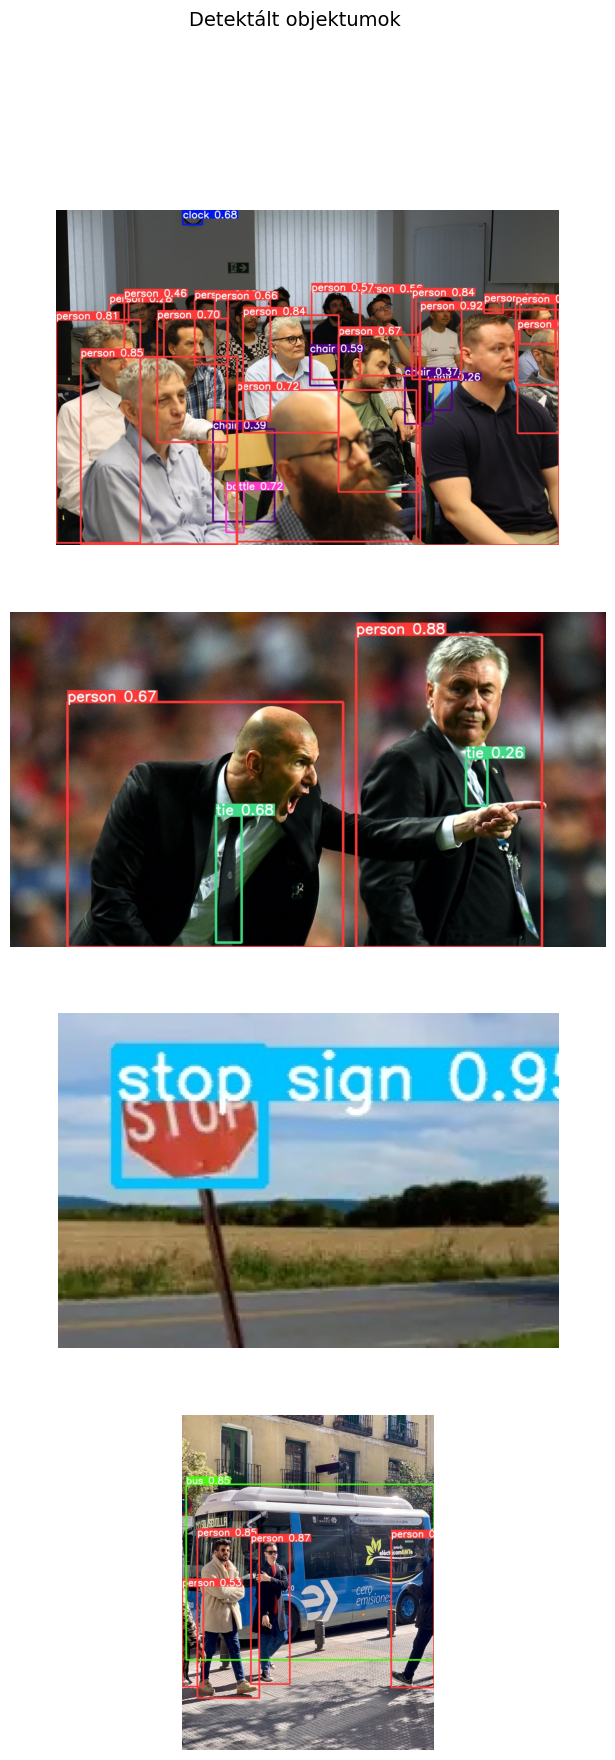

In [25]:
im_list = glob.glob('runs/detect/exp/*.jpg')
n = len(im_list)
fig, axes = plt.subplots(n, 1, figsize=(10, n*5))
fig.suptitle('Detektált objektumok', fontsize=14)
for i in range(n):
    im = cv2.imread(im_list[i])
    axes[i].imshow( cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')